In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.4.1


In [2]:
# 08时数据
lv1_08 = pd.read_csv(r'I:\Data\Personal Data\graduation project\Code\Machine Learning\basicdata\2007_lv1_08.csv',index_col='Unnamed: 0')
Temperature_08 = pd.read_csv(r'I:\Data\Personal Data\graduation project\Code\Machine Learning\basicdata\2007_Temperature_08.csv',index_col='Unnamed: 0')
merge_dataset =pd.merge(lv1_08,Temperature_08,on=lv1_08.index)
merge_dataset.drop('key_0',axis=1,inplace=True)
print(merge_dataset.shape)

# 20时数据
lv1_08 = pd.read_csv(r'I:\Data\Personal Data\graduation project\Code\Machine Learning\basicdata\2007_lv1_20.csv',index_col='Unnamed: 0')
Temperature_08 = pd.read_csv(r'I:\Data\Personal Data\graduation project\Code\Machine Learning\basicdata\2007_Temperature_20.csv',index_col='Unnamed: 0')
merge_dataset1 =pd.merge(lv1_08,Temperature_08,on=lv1_08.index)
merge_dataset1.drop('key_0',axis=1,inplace=True)
print(merge_dataset1.shape)
# 连接
merge_dataset = merge_dataset.append(merge_dataset1)

# 将'Rain'列转换为离散数值
merge_dataset['Rain'] = pd.Categorical(merge_dataset['Rain'])
merge_dataset['Rain'] = merge_dataset.Rain.cat.codes

# 去除空数据
merge_dataset[merge_dataset<-1000] = np.nan
merge_dataset.dropna(inplace=True)

# 去除['10','Azim', 'Elev']几列
# 温度训练
merge_dataset.drop(['10','Rain', 'TkBB(K)','Rh(%)', 'Pres(mb)', 'Tir(K)', 'Azim', 'Elev',' 22.235', ' 23.035', ' 23.835', ' 26.235', ' 30.000'],axis=1,inplace=True)

(365, 68)
(365, 68)


In [3]:
merge_dataset = merge_dataset.round(1)

In [4]:
# input:18
# output:47
merge_dataset.columns

Index(['Tamb(K)', ' 51.250', ' 52.280', ' 53.850', ' 54.940', ' 56.660',
       ' 57.290', ' 58.800', '0.00', '0.10', '0.20', '0.30', '0.40', '0.50',
       '0.60', '0.70', '0.80', '0.90', '1.00', '1.25', '1.50', '1.75', '2.00',
       '2.25', '2.50', '2.75', '3.00', '3.25', '3.50', '3.75', '4.00', '4.25',
       '4.50', '4.75', '5.00', '5.25', '5.50', '5.75', '6.00', '6.25', '6.50',
       '6.75', '7.00', '7.25', '7.50', '7.75', '8.00', '8.25', '8.50', '8.75',
       '9.00', '9.25', '9.50', '9.75', '10.00'],
      dtype='object')

In [5]:
# 归一化
def norm(x):
  return (x - merge_dataset.describe().transpose()['mean']) / merge_dataset.describe().transpose()['std']

merge_dataset.iloc[:,:8] = norm(merge_dataset).iloc[:,:8]

In [6]:
# 乱序，分离训练数据与测试数据
train_data = merge_dataset.sample(frac=0.8,random_state=0)
test_data = merge_dataset.drop(train_data.index)
# 分离标签
train_labels = train_data.iloc[:,8:]
test_labels = test_data.iloc[:,8:]
train_data.drop(train_labels.columns,axis=1,inplace=True)
test_data.drop(train_labels.columns,axis=1,inplace=True)

print(train_data.shape,test_data.shape,train_labels.shape,test_labels.shape)

(257, 8) (20, 8) (257, 47) (20, 47)


D:\Anaconda\envs\tf\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
def build_model():
  model = keras.Sequential([
    layers.Dense(len(train_data.keys()), activation='relu', input_shape=[len(train_data.keys())]),
    layers.Dense(23, activation='relu'),
    layers.Dense(47)
  ])

  opt = tf.keras.optimizers.RMSprop(0.001)
  # tf.train.GradientDescentOptimizer(0.001)
  # tf.keras.optimizers.RMSprop(0.001)
  # tf.optimizers.Adam(1e-3)

  model.compile(loss='mse', #损失函数
                optimizer=opt, # 优化器
                metrics=['mae', 'mse'] # 性能评估指标
                )
  return model

In [8]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 23)                207       
_________________________________________________________________
dense_2 (Dense)              (None, 47)                1128      
Total params: 1,407
Trainable params: 1,407
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(train_data,
                    train_labels,
                    batch_size=32,
                    epochs=1500, 
                    verbose=0,
                    validation_split = 0.2)

In [10]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
1495,5.520196,1.786610,5.520196,6.266629,1.850449,6.266629,1495
1496,5.817475,1.847359,5.817475,6.797326,1.900242,6.797326,1496
1497,5.455608,1.755084,5.455608,7.100876,1.937432,7.100876,1497
1498,5.547334,1.795008,5.547334,5.907738,1.751725,5.907738,1498
1499,5.543720,1.787695,5.543720,6.995959,1.931820,6.995960,1499


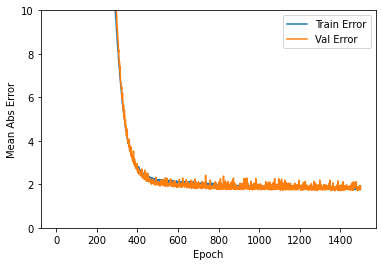

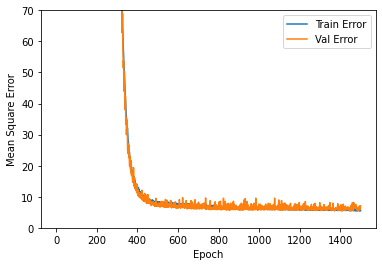

In [11]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,10])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,70])
  plt.legend()
  plt.show()


plot_history(history)

In [12]:
loss, mae, mse = model.evaluate(test_data, test_labels, verbose=1)

print("MAE: {:5.2f} ".format(mae))
print("MSE: {:5.2f} ".format(mse))
print("LOSS: {:5.2f} ".format(loss))

1/1 [==============================] - 0s 33ms/step - loss: 5.7158 - mae: 1.8020 - mse: 5.7158
MAE:  1.80 
MSE:  5.72 
LOSS:  5.72 


In [13]:
example_result = model.predict(train_data[:10],
                                verbose=2)
example_result

1/1 - 0s


array([[273.2172 , 272.33017, 271.82913, 271.11545, 270.23517, 269.6715 ,
        268.78647, 268.2443 , 267.50888, 266.5983 , 265.96213, 264.18414,
        262.8446 , 260.99472, 259.42593, 257.65622, 255.8656 , 254.44824,
        252.47849, 250.95932, 249.26367, 247.12039, 245.22743, 243.47958,
        241.62447, 239.92035, 238.38441, 236.55676, 235.22943, 233.78134,
        232.43182, 231.31693, 229.82816, 228.27356, 227.31013, 225.62001,
        224.30748, 223.38515, 222.46402, 221.24506, 220.3175 , 219.49712,
        218.3489 , 217.53827, 216.12863, 214.84433, 213.89952],
       [274.02496, 273.72943, 273.21088, 272.76434, 272.40668, 271.87857,
        271.5115 , 270.97083, 270.5679 , 270.26584, 269.61578, 268.17178,
        266.47397, 265.05225, 263.55002, 262.11743, 260.7152 , 259.11578,
        257.55203, 255.69048, 254.00494, 252.48056, 250.80904, 249.03012,
        247.23283, 245.57355, 243.72978, 242.10829, 240.1534 , 238.35088,
        236.46663, 234.5257 , 232.88197, 231.227